# KOSPI 지수를 통한 Modeling

In [1]:
# # KOSPI지수를 가져오기 위한 library인 FinanceDataReader install
# !pip install -U finance-datareader

In [2]:
# # install fonts
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
# library import
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
# # Time series decomposition
# !pip install stldecompose
from stldecompose import decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
# 시각화 모듈 임포트
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import font_manager, rc

# colab 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False

# font 적용
plt.rc('font', family = 'NanumBarunGothic')

# ggplot 으로 그래프 스타일 설정
plt.style.use('ggplot')

# 레티나 설정 : 글자가 흐릿하게 보이는 현상 방지
%config InlineBackend.figure_format = 'retina'

# warning 방지
import warnings  
warnings.filterwarnings(action = 'ignore')

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

### KOSPI 과거 지수 가져오기

분석하려는 **KOSPI지수**에 대한 과거 데이터 프레임을 가져옵니다.  
**FinanceDataReader**를 통해 가져오고 데이터양을 줄이기 위해 2000년 부터 가져오기로 하였습니다.

In [13]:
# KS11 (KOSPI 지수), 2015년~현재
df = fdr.DataReader('KS11', '2000')

In [14]:
df = df.reset_index()
df.head()

,Date,Close,Open,High,Low,Volume,Change
0,2000-01-04,1059.04,1028.33,1066.18,1016.59,195900000.0,0.0301
1,2000-01-05,986.31,1006.87,1026.52,984.05,257700000.0,-0.0687
2,2000-01-06,960.79,1013.95,1014.90,953.50,203520000.0,-0.0259
3,2000-01-07,948.65,949.17,970.16,930.84,215660000.0,-0.0126
4,2000-01-10,987.24,979.67,994.94,965.02,240180000.0,0.0407


In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2000)].copy()
df.index = range(len(df))

df.head()

,Date,Close,Open,High,Low,Volume,Change
0,2000-01-04,1059.04,1028.33,1066.18,1016.59,195900000.0,0.0301
1,2000-01-05,986.31,1006.87,1026.52,984.05,257700000.0,-0.0687
2,2000-01-06,960.79,1013.95,1014.90,953.50,203520000.0,-0.0259
3,2000-01-07,948.65,949.17,970.16,930.84,215660000.0,-0.0126
4,2000-01-10,987.24,979.67,994.94,965.02,240180000.0,0.0407


### OHLC Chart  
과거 가격을 이해하기 위해서 OHLC(시가/고가/저가/종가)데이터에 대해서 차트를 그리면서 분석을 시작하겠습니다.  
* **OHLC 차트**는 주식의 시가, 고가, 저가 및 종가를 보여줍니다. 특정 날짜에 가격이 어떻게 변했는지 보여주고 예를 들어 주식의 모멘텀 또는 변동성. 선의 끝은 낮은 값과 높은 값을 나타내고 가로 세그먼트는 시가와 종가를 나타냅니다. 종가가 더 높은(낮은) 샘플 포인트를 오픈 값이 증가(감소)라고 합니다. 기본적으로 증가하는 항목은 녹색으로 그려지고 감소하는 항목은 빨간색으로 그려집니다.  
* **거래량(Volume)**은 특정 기간 동안 거래(구매, 판매)된 주식의 수를 보여주는 매우 기본적인 척도입니다. 거래량은 기본적으로 주식 거래의 활동을 나타내기 때문에 매우 중요합니다. 거래량 가치가 높을수록 주식 거래에 대한 관심이 높음을 나타냅니다.

In [16]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show();

### Decomposition
* Observed : 위에서 보신 KOSPI의 값을 그려주는 plot
* Trend(추세) : 시계열이 시간에 따라 증가, 감소 또는 일정 수준을 유지하는 경우  
* Seasonal(계절성) : 일정한 빈도로 주기적 반복되는 패턴, 특정한 달/요일에 따라 기대값이 달라지는 것  
    * 계절성 반영이 큰 2가지 : 수치값 그대로 or 발생시점 으로 분리  
* Residual(잔차) : Observed에서 추세와 계절성을 뺀 값을 보여주는 plot  

이렇게 Decomposition이라는 library를 통해 시계열 데이터를 분해 할 수 있습니다.

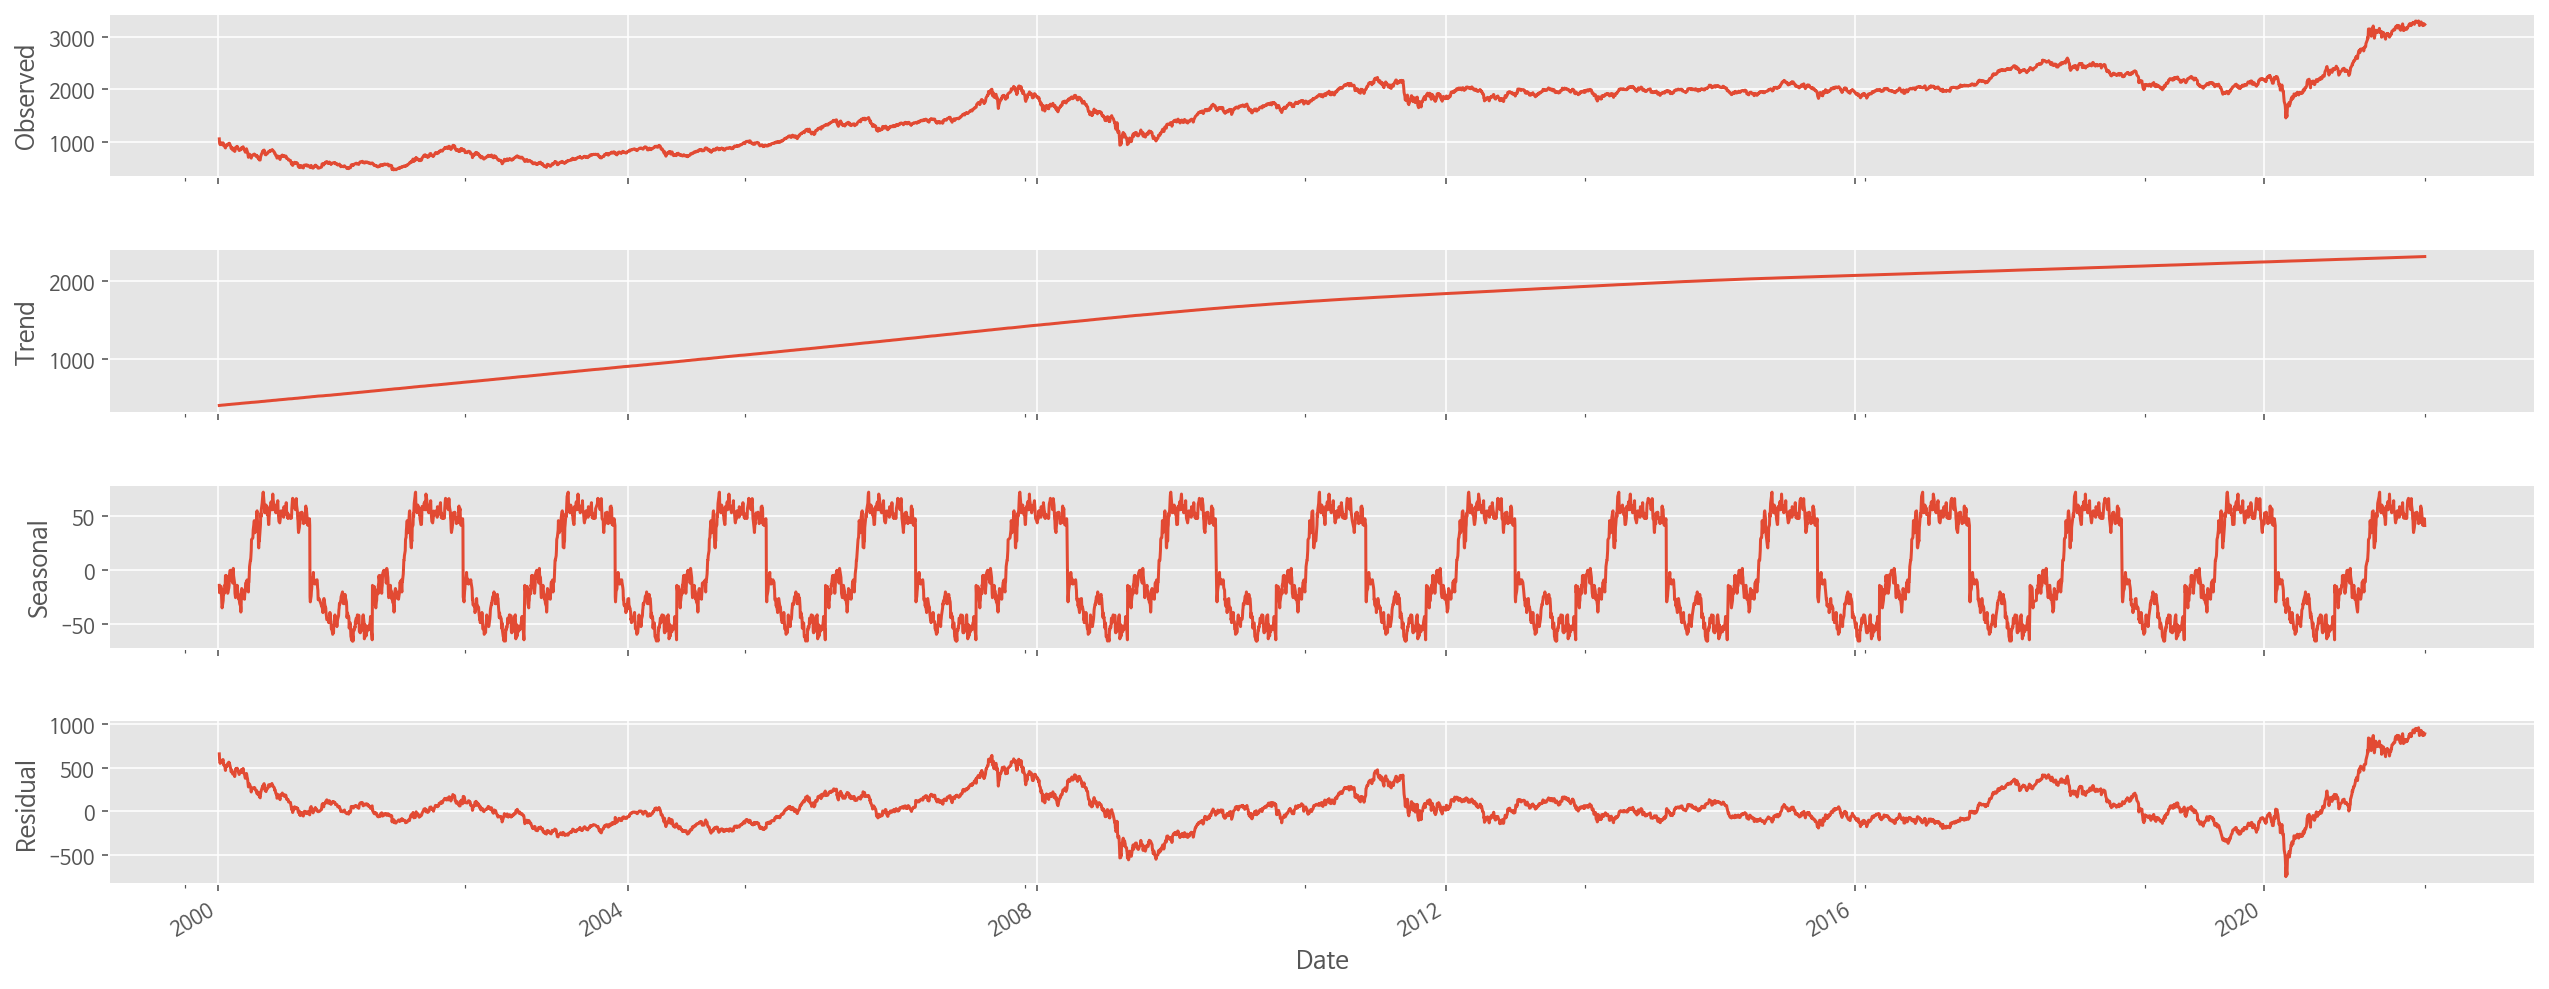

In [17]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

### Moving Average  

* 이동 평균(MA)은 단기 가격 변동을 필터링하여 차트에서 주가를 부드럽게 만드는 데 도움이 됩니다. 정의된 기간 동안 이동 평균을 계산합니다. 지난 9, 50 또는 200일. 기술적 분석에 사용되는 두 가지(가장 일반적인) 평균은 다음과 같습니다.  
     * Simple Moving Average (SMA) : 지난 N일 동안 계산된 단순 평균 50, 100 또는 200  
     * Exponential Moving Average (EMA) : 최근 가격에 더 큰 가중치가 적용된 평균입니다.

In [18]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show();

### Relative Strength Index(RSI)  
* 일반적으로 사용되는 또 다른 지표는 최근 가격 변동의 규모를 나타내는 상대 강도 지수(RSI)입니다. 주식이 과매수 또는 과매도 상태임을 나타낼 수 있습니다. 일반적으로 RSI 값이 70 이상이면 주식이 과매수/과대평가되고 있다는 신호이고, 30 이하이면 과매도 상태임을 의미할 수 있습니다. RSI의 전체 범위는 0에서 100입니다.

In [19]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show();

### Moving Average Convergence Divergence (MACD)  
* MACD는 두 지수 이동 평균(12일 및 26일 EMA) 간의 관계를 보여주는 지표입니다. 우리는 12일 EMA(또는 빠른 EMA)에서 26일 EMA(저속 EMA라고도 함)를 빼서 MACD를 얻습니다.

In [20]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show();

### Shift label column
* 다음 날 가격을 예측하고 싶기 때문에 $D_i$ day의 모든 특성을 계산한 후 Close price 열을 -1 행만큼 이동합니다. 그렇게 한 후, $D_i$에 대해 동일한 타임스탬프의 기능이 있습니다. $RSI_i$ , 그러나 가격은 다음 날부터 $C_{i+1}$입니다.

In [21]:
df['Close'] = df['Close'].shift(-1)

### Drop invalid samples  
* 이동 평균을 계산하고 레이블 열을 이동하기 때문에 잘못된 값이 있는 행은 거의 없습니다. 처음 10일 동안 SMA10을 계산하지 않았습니다. 또한 Close price 열을 이동한 후 마지막 행의 가격은 0이 되며 이는 사실이 아니기 때문에 이러한 샘플을 제거하면 도움이 됩니다.

In [22]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [23]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show();

### Drop unnecessary columns

In [24]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Change']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

### Split into features and labels

In [25]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        3706 non-null   float64
 1   SMA_5        3706 non-null   float64
 2   SMA_10       3706 non-null   float64
 3   SMA_15       3706 non-null   float64
 4   SMA_30       3706 non-null   float64
 5   RSI          3706 non-null   float64
 6   MACD         3706 non-null   float64
 7   MACD_signal  3706 non-null   float64
dtypes: float64(8)
memory usage: 231.8 KB


### Fine-tune XGBoostRegressor

In [26]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [333]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'random_state': 333}
Best validation score = 0.888692642440018
CPU times: user 22min 32s, sys: 6.6 s, total: 22min 38s
Wall time: 22min 33s


In [27]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 1.68 s, sys: 11 ms, total: 1.69 s
Wall time: 1.69 s


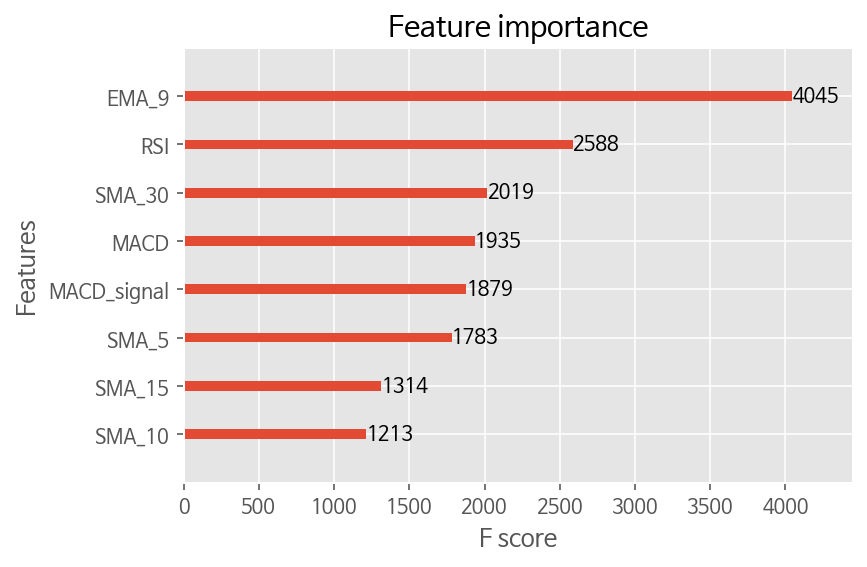

In [28]:
plot_importance(model);

### Calculate and visualize predictions

In [29]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [2464.16 2477.71 2476.11 2458.54 2459.82]
y_pred = [2111.1777 2109.704  2109.801  2110.3237 2110.9902]


In [30]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 222739.53550534655


In [31]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()